In [1]:
!pip install gdown

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from tqdm import tqdm

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)

In [4]:
# Download the dataset
datasets.Caltech101(root='./dataset', download=True)

Downloading...
From (original): https://drive.google.com/uc?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp
From (redirected): https://drive.usercontent.google.com/download?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp&confirm=t&uuid=adbe3192-9996-42f5-87e4-998a709009a1
To: /kaggle/working/dataset/caltech101/101_ObjectCategories.tar.gz
100%|██████████| 132M/132M [00:00<00:00, 203MB/s] 


Extracting ./dataset/caltech101/101_ObjectCategories.tar.gz to ./dataset/caltech101


Downloading...
From (original): https://drive.google.com/uc?id=175kQy3UsZ0wUEHZjqkUDdNVssr7bgh_m
From (redirected): https://drive.usercontent.google.com/download?id=175kQy3UsZ0wUEHZjqkUDdNVssr7bgh_m&confirm=t&uuid=1ab30462-c5a5-4807-87d5-0c0369f91363
To: /kaggle/working/dataset/caltech101/Annotations.tar
100%|██████████| 14.0M/14.0M [00:00<00:00, 44.2MB/s]


Extracting ./dataset/caltech101/Annotations.tar to ./dataset/caltech101


Dataset Caltech101
    Number of datapoints: 8677
    Root location: ./dataset/caltech101
    Target type: ['category']

In [5]:
class ImageDataset(Dataset):
    
    def __init__(self, root, transform=None, target_transform=None, ignores=[]):
        super().__init__()
        self.root = root
        self.transform = transform
        self.target_transform = target_transform
        self.ignores = ignores

        self.classes = os.listdir(root)
        for ignore in ignores:
            self.classes.remove(ignore)

        self.targets = []
        self.image_paths = []
        self.class_to_idx = {}

        for class_idx, class_name in enumerate(self.classes):
            class_path = os.path.join(root, class_name)
            if not os.path.isdir(class_path):
                continue

            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                self.image_paths.append(image_path)
                self.targets.append(class_idx)

            self.class_to_idx[class_name] = class_idx

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index]).convert("RGB")
        target = self.targets[index]

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            target = self.target_transform(target)

        return image, target

    def __len__(self) -> int:
        return len(self.image_paths)

In [6]:
class Classifier(nn.Module):

    def __init__(self, num_classes):
        super().__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        self.blocks = nn.ModuleList()
        self.shortcut_convs = nn.ModuleList()
        sizes = [256, 512, 728]

        in_channels = 128
        for out_channels in sizes:
            self.blocks.append(self._make_block(in_channels, out_channels))
            self.shortcut_convs.append(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2))
            in_channels = out_channels

        self.top_sep_conv = self._separable_conv(in_channels, 1024)
        self.top_bn = nn.BatchNorm2d(1024)
        self.top_relu = nn.ReLU()
        self.top_global_pool = nn.AdaptiveAvgPool2d(1)
        self.top_dropout = nn.Dropout(0.3)
        if num_classes == 2:
            self.predictions = nn.Linear(1024, 1)
        else:
            self.predictions = nn.Linear(1024, num_classes)

    def _separable_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels,
                      in_channels,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      groups=in_channels),
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            )

    def _make_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ReLU(),
            self._separable_conv(in_channels, out_channels),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            self._separable_conv(out_channels, out_channels),
            nn.BatchNorm2d(out_channels),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        nn.softmax

    def forward(self, x):
        x = self.stem(x)

        for block, shortcut_conv in zip(self.blocks, self.shortcut_convs):
            residual = shortcut_conv(x)
            x = block(x) + residual

        x = self.top_sep_conv(x)
        x = self.top_bn(x)
        x = self.top_relu(x)
        x = self.top_global_pool(x).view(x.size(0), -1)
        x = self.top_dropout(x)
        x = self.predictions(x)
        return x

In [7]:
bar_format = "{n_fmt}/{total_fmt} |{bar}| [{elapsed}<{remaining},{rate_fmt}]{postfix}"
progress_bar = lambda iter: tqdm(iter, bar_format=bar_format)

In [8]:
def validate_model(model, criterion, val_loader):
    model.eval()
    acc_loss = 0.0
    acc_correct = 0

    with torch.no_grad():
        for X, y in val_loader:
            y_pred = model(X)
            batch_loss = criterion(y_pred, y)
            _, predicted = torch.max(y_pred, dim=1)

            acc_loss += batch_loss
            acc_correct += (predicted == y).sum().item()

    loss = acc_loss / len(val_loader)
    accuracy = acc_correct / len(val_loader.dataset)
    return loss.item(), accuracy

In [16]:
def train_model(dataloader, model, criterion, optimizer, num_epochs, val_loader=None):
    loss_hist = []
    accuracy_hist = []
    if val_loader:
        val_loss_hist = []
        val_accuracy_hist = []

    for epoch in range(num_epochs):
        model.train()
        print(f"Epoch {epoch + 1}/{num_epochs}")

        acc_loss = 0.0
        acc_accuracy = 0

        pbar = progress_bar(dataloader)
        for X, y in pbar:
            # Clear the previous gradient
            optimizer.zero_grad()

            # Forward pass
            y_pred = model(X)
            batch_loss = criterion(y_pred, y)

            # Backward pass
            batch_loss.backward()
            optimizer.step()

            _, predicted = torch.max(y_pred, dim=1)
            acc_loss += batch_loss.item()
            acc_accuracy += (predicted == y).sum().item()

        loss = acc_loss / len(dataloader)
        accuracy = acc_accuracy / len(dataloader.dataset)

        loss_hist.append(loss)
        accuracy_hist.append(accuracy)

        if val_loader:
            val_loss, val_accuracy = validate_model(model, criterion, val_loader)
            val_loss_hist.append(val_loss)
            val_accuracy_hist.append(val_accuracy)

            print(f"acc: {accuracy:.4f} - loss: {loss:.4f} - "
                  f"val_acc: {val_accuracy:.4f} - val_loss: {val_loss:.4f}")
        else:
            print(f"acc: {accuracy:.4f} - loss: {loss:.4f}")

    history = {
        'loss': loss_hist,
        'accuracy': accuracy_hist
    }
    if val_loader:
        history['val_loss'] = val_loss_hist
        history['val_accuracy'] = val_accuracy_hist

    return history

In [17]:
from torchvision.transforms import v2

mean = torch.Tensor([0.485, 0.456, 0.406]).to(device)
std = torch.Tensor([0.229, 0.224, 0.225]).to(device)

# Define transformations
train_transform = v2.Compose([
    v2.ToImage(),
    v2.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    v2.Resize((224, 224)),
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(20),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=mean.tolist(), std=std.tolist()),
])

val_transform = v2.Compose([
    v2.ToImage(),
    v2.Resize((224, 224)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=mean.tolist(), std=std.tolist()),
])

In [18]:
from torch.utils.data import Subset, random_split

root = "./dataset/caltech101/101_ObjectCategories"
ignores = ["BACKGROUND_Google"]
dataset = ImageDataset(root, ignores=ignores)

# Split ratio
splits_ratio = [0.6, 0.2, 0.2]

# Split the dataset
num_samples = len(dataset.targets)
train_indices, val_indices, test_indices = random_split(
    range(num_samples), splits_ratio, generator=torch.Generator(device))

# Create datasets with different transforms
train_ds = ImageDataset(root, transform=train_transform, ignores=ignores)
val_ds = ImageDataset(root, transform=val_transform, ignores=ignores)

# Create subsets based on the indices
train_ss = Subset(train_ds, train_indices)
val_ss = Subset(val_ds, val_indices)
test_ss = Subset(val_ds, test_indices)

# Create dataloader
train_loader = DataLoader(train_ss, batch_size=32, shuffle=True, generator=torch.Generator(device))
val_loader = DataLoader(val_ss, batch_size=32)
test_loader = DataLoader(test_ss, batch_size=32)

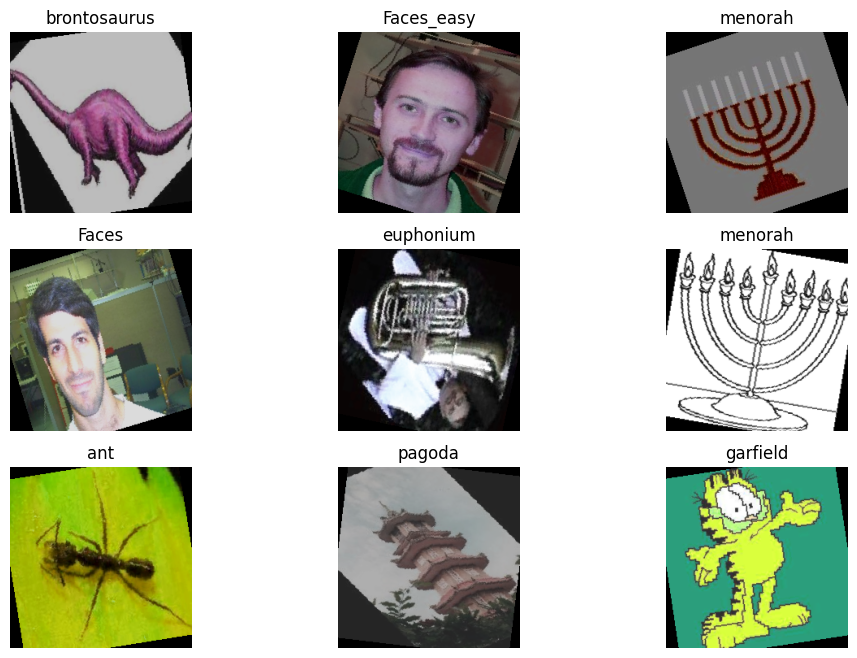

In [19]:
# Train images after the transformation
rows, cols = 3, 3

fig = plt.figure(figsize=(12, 8))
for i in range(rows * cols):
    sample_idx = torch.randint(len(train_ds), size=(1, )).item()
    image, label = train_ds[sample_idx]
    image = image * std.view(3, 1, 1) + mean.view(3, 1, 1)
    image = torch.round(image, decimals=4)

    fig.add_subplot(rows, cols, i + 1)
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())
    plt.title(train_ds.classes[label])
    plt.axis("off")
plt.show()

In [20]:
num_classes = len(dataset.classes)
lr = 5e-3

model = Classifier(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [21]:
num_epochs = 30
history = train_model(train_loader, model, criterion, optimizer, num_epochs, val_loader)

Epoch 1/30


163/163 |██████████| [01:39<00:00, 1.64it/s]


acc: 0.1218 - loss: 4.4198 - val_acc: 0.1597 - val_loss: 4.0316
Epoch 2/30


163/163 |██████████| [01:39<00:00, 1.64it/s]


acc: 0.1730 - loss: 3.9673 - val_acc: 0.1908 - val_loss: 3.8612
Epoch 3/30


163/163 |██████████| [01:39<00:00, 1.64it/s]


acc: 0.2068 - loss: 3.7698 - val_acc: 0.2144 - val_loss: 3.5356
Epoch 4/30


163/163 |██████████| [01:39<00:00, 1.64it/s]


acc: 0.2452 - loss: 3.5177 - val_acc: 0.2594 - val_loss: 3.4127
Epoch 5/30


163/163 |██████████| [01:39<00:00, 1.64it/s]


acc: 0.2915 - loss: 3.2705 - val_acc: 0.3297 - val_loss: 3.0700
Epoch 6/30


163/163 |██████████| [01:39<00:00, 1.64it/s]


acc: 0.3324 - loss: 3.0222 - val_acc: 0.3614 - val_loss: 2.7793
Epoch 7/30


163/163 |██████████| [01:39<00:00, 1.64it/s]


acc: 0.3714 - loss: 2.7947 - val_acc: 0.3873 - val_loss: 2.6804
Epoch 8/30


163/163 |██████████| [01:39<00:00, 1.64it/s]


acc: 0.4004 - loss: 2.6101 - val_acc: 0.4277 - val_loss: 2.7059
Epoch 9/30


163/163 |██████████| [01:39<00:00, 1.64it/s]


acc: 0.4298 - loss: 2.4398 - val_acc: 0.4720 - val_loss: 2.2522
Epoch 10/30


163/163 |██████████| [01:39<00:00, 1.64it/s]


acc: 0.4642 - loss: 2.2532 - val_acc: 0.5049 - val_loss: 2.1101
Epoch 11/30


163/163 |██████████| [01:39<00:00, 1.64it/s]


acc: 0.4976 - loss: 2.1113 - val_acc: 0.5061 - val_loss: 2.0708
Epoch 12/30


163/163 |██████████| [01:39<00:00, 1.64it/s]


acc: 0.5220 - loss: 1.9507 - val_acc: 0.4968 - val_loss: 2.2970
Epoch 13/30


163/163 |██████████| [01:39<00:00, 1.64it/s]


acc: 0.5437 - loss: 1.8302 - val_acc: 0.4352 - val_loss: 2.5925
Epoch 14/30


163/163 |██████████| [01:39<00:00, 1.64it/s]


acc: 0.5667 - loss: 1.7399 - val_acc: 0.5620 - val_loss: 1.8076
Epoch 15/30


163/163 |██████████| [01:39<00:00, 1.65it/s]


acc: 0.5879 - loss: 1.6247 - val_acc: 0.6161 - val_loss: 1.5937
Epoch 16/30


163/163 |██████████| [01:38<00:00, 1.65it/s]


acc: 0.6188 - loss: 1.4952 - val_acc: 0.6225 - val_loss: 1.5361
Epoch 17/30


163/163 |██████████| [01:38<00:00, 1.65it/s]


acc: 0.6411 - loss: 1.4120 - val_acc: 0.6179 - val_loss: 1.6347
Epoch 18/30


163/163 |██████████| [01:38<00:00, 1.65it/s]


acc: 0.6503 - loss: 1.3317 - val_acc: 0.5718 - val_loss: 1.8829
Epoch 19/30


163/163 |██████████| [01:39<00:00, 1.64it/s]


acc: 0.6752 - loss: 1.2389 - val_acc: 0.6490 - val_loss: 1.4459
Epoch 20/30


163/163 |██████████| [01:39<00:00, 1.64it/s]


acc: 0.6983 - loss: 1.1584 - val_acc: 0.6847 - val_loss: 1.3443
Epoch 21/30


163/163 |██████████| [01:40<00:00, 1.63it/s]


acc: 0.7039 - loss: 1.0858 - val_acc: 0.6841 - val_loss: 1.1805
Epoch 22/30


163/163 |██████████| [01:39<00:00, 1.64it/s]


acc: 0.7227 - loss: 1.0378 - val_acc: 0.6784 - val_loss: 1.4133
Epoch 23/30


163/163 |██████████| [01:39<00:00, 1.64it/s]


acc: 0.7459 - loss: 0.9370 - val_acc: 0.6997 - val_loss: 1.2287
Epoch 24/30


163/163 |██████████| [01:39<00:00, 1.64it/s]


acc: 0.7596 - loss: 0.8625 - val_acc: 0.6634 - val_loss: 1.4114
Epoch 25/30


163/163 |██████████| [01:39<00:00, 1.64it/s]


acc: 0.7684 - loss: 0.8237 - val_acc: 0.6974 - val_loss: 1.2486
Epoch 26/30


163/163 |██████████| [01:39<00:00, 1.64it/s]


acc: 0.7824 - loss: 0.7777 - val_acc: 0.7118 - val_loss: 1.1423
Epoch 27/30


163/163 |██████████| [01:39<00:00, 1.64it/s]


acc: 0.7887 - loss: 0.7505 - val_acc: 0.7078 - val_loss: 1.2008
Epoch 28/30


163/163 |██████████| [01:40<00:00, 1.63it/s]


acc: 0.8062 - loss: 0.6658 - val_acc: 0.7084 - val_loss: 1.1935
Epoch 29/30


163/163 |██████████| [01:39<00:00, 1.64it/s]


acc: 0.8133 - loss: 0.6435 - val_acc: 0.7424 - val_loss: 1.0720
Epoch 30/30


163/163 |██████████| [01:39<00:00, 1.64it/s]


acc: 0.8256 - loss: 0.5994 - val_acc: 0.7303 - val_loss: 1.1179


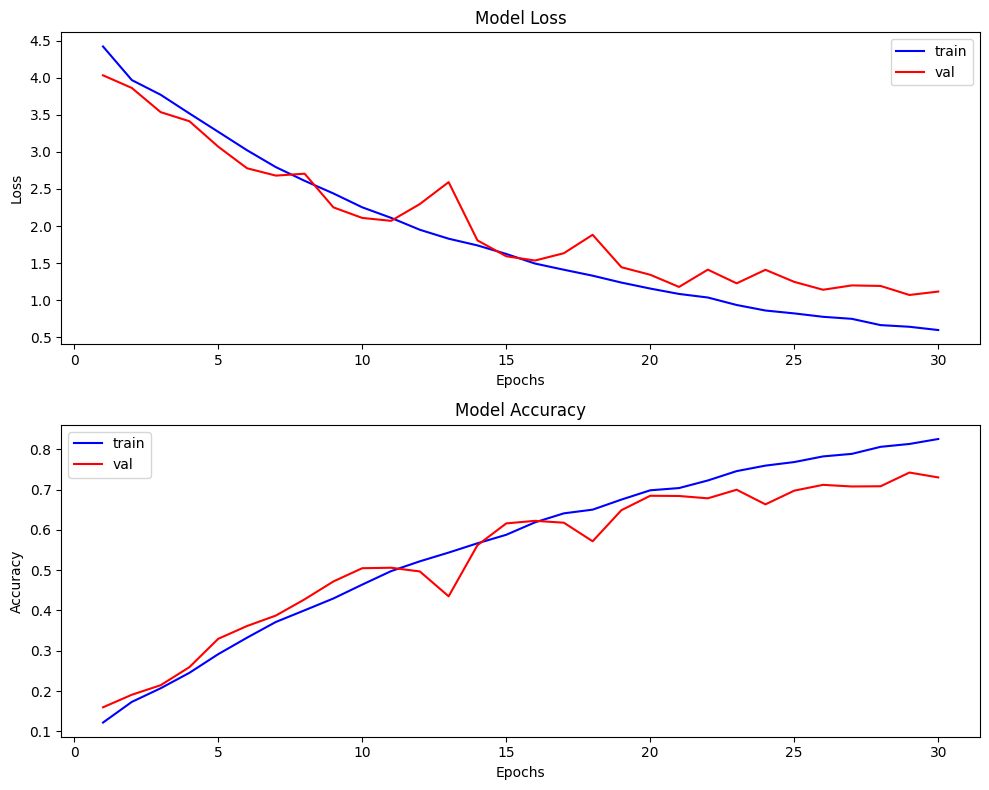

In [22]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

ax1.plot(range(1, num_epochs + 1), history['loss'], label='train', color='blue')
ax1.plot(range(1, num_epochs + 1), history['val_loss'], label='val', color='red')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(range(1, num_epochs + 1), history['accuracy'], label='train', color='blue')
ax2.plot(range(1, num_epochs + 1), history['val_accuracy'], label='val', color='red')
ax2.set_title('Model Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

In [24]:
def test_model(model, test_loader):
    model.eval()
    acc_correct = 0

    with torch.no_grad():
        for X, y in test_loader:
            y_pred = model(X)
            _, predicted = torch.max(y_pred, dim=1)
            acc_correct += (predicted == y).sum().item()

    accuracy = acc_correct / len(test_loader.dataset)
    return accuracy

In [25]:
test_acc = test_model(model, test_loader)
print(f"Accuracy on test set: {test_acc}")

Accuracy on test set: 0.738328530259366
